# GG4257 - Urban Analytics
---
## Assignment 1 : Lab 2 Challenges
---
- <a href="#Challenge-1:">Challenge 1</a>
- <a href="#Challenge-2:">Challenge 2</a>
---

### Challenge 1:

This challenge included 4 parts to it, so I will tackle each part one at a time.

1. Using a Dictionary, create a dataframe (table), with at least 4 columns and more than 100 rows. How come you can create this among data from scratch without defining every single row of data? 


In [ ]:
import pandas as pd
import numpy as np

#defining the dictionary
inBloom = ('yes','no')
flowers = ('buttercup', 'daisy', 'tulip', 'heather', 'cow parsley')
bloom = np.repeat(inBloom, 50) #repeats whether they're in bloom or not
flowertype = np.repeat(flowers, 20) # repeats flowertype
num = range(1, 11) # list of numbers 1 to 11
field = np.repeat(num, 10) #this uses numpy's repeat() function to repeat values
clustered = np.random.randint(2, 10, 100) # the randint() function can be used to generate random integers - in this case 32 values between 0 and 40

#Create data frame from dictionary
meadow = pd.DataFrame({'flowers':flowertype,'bloom':bloom, 'cluster':clustered, 'num':field})
meadow

Here we define a few arrays and allow them to fill up using numpy commands until each array has a length of 100. Then we put these into a dictionary that we define as our dataframe

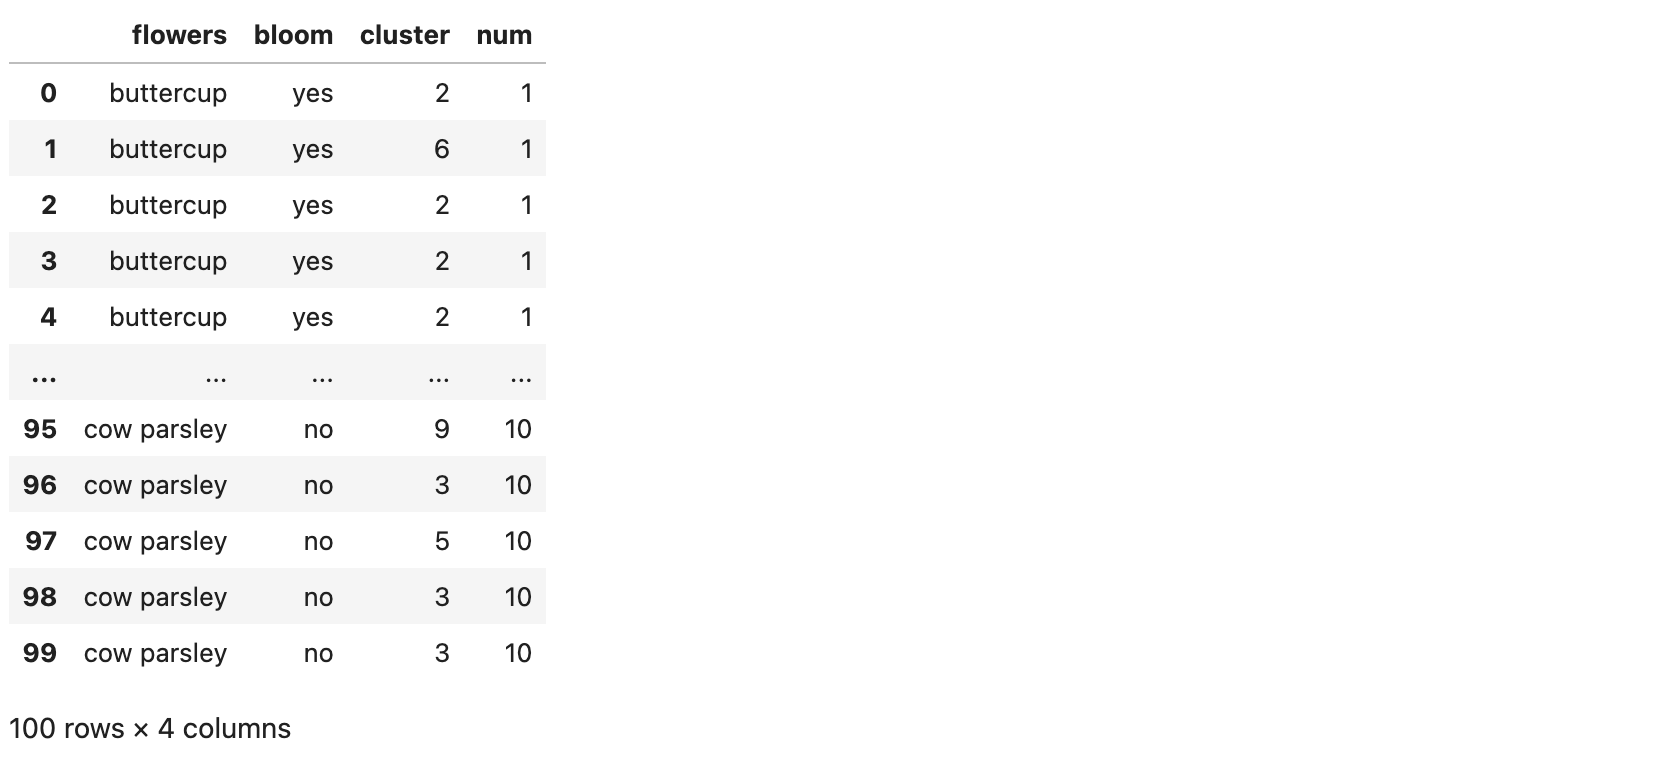

2. Using the appropriate method, create a new DataFrame containing only the first 30 rows and the first 3 columns of the original DataFrame. Name this new DataFrame subset_df.


In [ ]:
subset_df = meadow.iloc[:30, :3] #subsetting using index requires iloc

3. Using the appropriate method, filter the rows from the original dataframe where a numerical attribute(column) is greater than a particular numerical value, and find another categorical attribute that is equal to a specific string or text. Name this new DataFrame filtered_df.


In [ ]:
filtered_df = meadow.loc[(meadow['cluster']>7) & (meadow['flowers']=='buttercup')] 
# subsetting using loc as we're subsetting by value not index

4. Check this website https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html and apply the methods, mean, standard deviation, group_by to run fundamental statistical analysis of your created data frame.

In [ ]:
# running statistical analysis individually
meadow.mean(numeric_only=True) # mean of numeric attributes 
meadow.median(numeric_only=True) #median of numeric attributes

In [ ]:
meadow.groupby(['flowers']).describe() # using group by and describe to retrieve all available stats

Output pictured here (although this will change each time the code is run due to the use of randomisers meaning that the contents of the dataframe will never be the same each time it's run
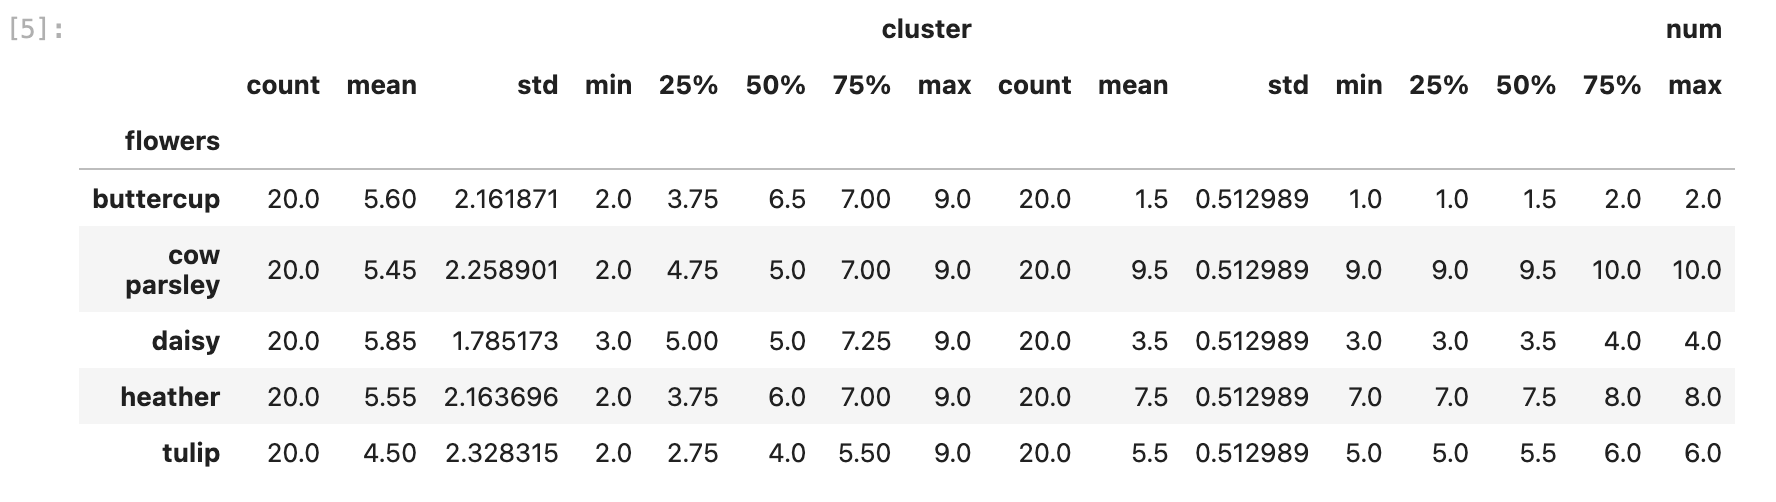

### Challenge 2:

**Part No 1:**

1. Using the same workflow previously described, now calculate the clustered areas for the GeoPandasDataFrame `gdf_bikes_end`
2. Make sure you don't have any NaN in your columns, add a CRS, clean up the unnecessary attributes, calculate the cluster values, and plot a map of 4 calculated clusters for the return locations.

In [ ]:
# importing everything we need!!
import requests
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import leafmap
from shapely.geometry import Point

In [ ]:
# code from the labbook to set us up to use the gdf_bikes_end dataframe!

url_bikes = "https://api.glasgow.gov.uk/mobility/v1/get_rentals?startDate=2022-05-01&endDate=2023-05-01"
response = requests.get(url_bikes)
data = response.json() #response is 200 so it worked!
rental_data = data['data']
rental_pd = pd.DataFrame(rental_data)

# dropping NAs
clean_rental_pd = rental_pd.dropna(subset=['startPlaceLat', 'startPlaceLong', 'endPlaceLat','endPlaceLong'])

# making the final dataframe a GeoDataFrame
gdf_bikes_end = gpd.GeoDataFrame(clean_rental_pd, geometry=gpd.points_from_xy(clean_rental_pd['endPlaceLong'], clean_rental_pd['endPlaceLat']))

In [ ]:
gdf_bikes_end.info() #having a look at all of the columns we have

In [ ]:
keep_cols = [
    "bikeId",
    "endDate",
    "endPlaceName",
    "endPlaceLat",
    "endPlaceLong",
    "geometry"
]
#the above lines of code clean up the data and just keep a few columns that could be relevant to this analysis

clean_gdf_bikes_end = gdf_bikes_end[keep_cols]
clean_gdf_bikes_end.head()

In [ ]:
# projecting the data!! creating latitude and longitude pairs and then projecting them into the right CRS
geom = [Point(xy) for xy in zip(clean_gdf_bikes_end.endPlaceLong, clean_gdf_bikes_end.endPlaceLat)]
projected_gdf_bikes_end = gpd.GeoDataFrame(clean_gdf_bikes_end, crs='EPSG:4326', geometry=geom)
projected_gdf_bikes_end.explore()

In [ ]:
noClusters = 4 # defining the number of clusters

# calculating clusters and adding a column for this to the dataframe
kmeans_collection = KMeans(n_clusters=noClusters, random_state=42)
projected_gdf_bikes_end['kmeans_cluster'] = kmeans_collection.fit_predict(projected_gdf_bikes_end[['endPlaceLong', 'endPlaceLat']])

In [ ]:
projected_gdf_bikes_end.head() # checking the dataframe

In [ ]:
# creating the map, centring and customising its functions
bikeMap = leafmap.Map(center=(55.860166, -4.257505),
                zoom=12,
                draw_control=False,
                measure_control=False,
                fullscreen_control=False,
                attribution_control=True,)

bikeMap.add_basemap("CartoDB.Positron")
# projecting the map using the clusters as the column
bikeMap.add_data(projected_gdf_bikes_end, column='kmeans_cluster',legend_title='Clusters',cmap='Set1',k=4,)

#Ploting the map
bikeMap

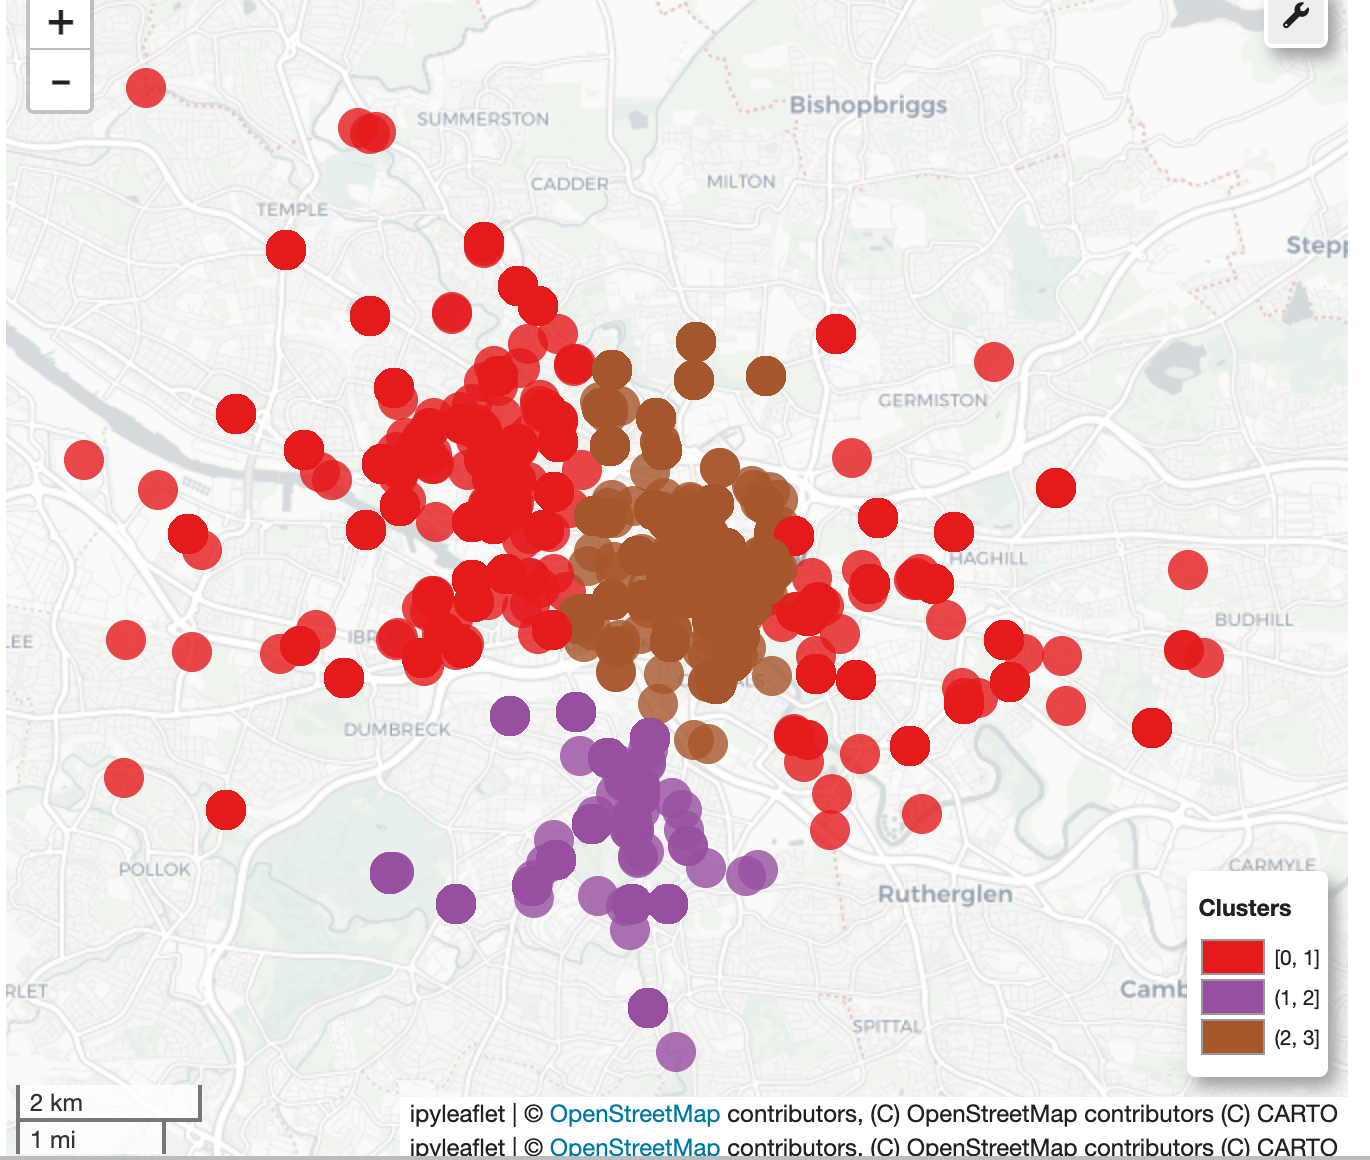

For this part of the challenge, we subset the data down to just the columns that could be relevant to this analysis. We drop any rows with NAs from the columns we want and transform the data into a GeoDataFrame. We then project the data into the right CRS and we can use the explore function to have a look at the data!
After this we start to define our clusters using the KMeans function, check the dataframe to ensure that the new column for the cluster has been sucessfully implemented, and then we can customise and plot the map, the result of which is shown above!

**Part No 2:**

1. Using the Glasglow Open Data API ( Transit) https://developer.glasgow.gov.uk/api-details#api=traffic&operation=traffic-sensor-locations fetch all the sensor locations in the city.
2. Map the sensor
3. Find the WorkingZones and Calculate/Map the areas with more and fewer sensors distributed in the city.
4. You will need:
   * Get two separate Geopandas DataFrames, one for the traffic sensors and another one for the WorkingZones.
   * Using `sJoin` ( Spatial Join) https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
   calculate the overlay of sensors and polygons.
   * Using group_by https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html to count the number of sensors per WorkingZone
   * Make sure you add the counts into the WorkingZone polygons of Glasgow so you can create a map of Zones with more and fewer traffic sensors.
   * Of course, you will need extra steps where you manipulate the data and extract what you need, for instance, clipping the Working Zones only for Glasgow.
5. Make sure you comment on your code and describe how you are manipulating the data.


In [ ]:
# using API to retrieve data
url_sensors = "https://api.glasgow.gov.uk/traffic/v1/movement/sites"
response = requests.get(url_sensors) #result is 200 so we know the request works!
sensor_data = response.json()


In [ ]:
# creating empty lists to enter data into
siteId_list=[]
lat_list=[]
long_list=[]
description_list = []

In [ ]:
# for loop to append data into the empty lists we just created
for entry in sensor_data:
    id_entry=entry['siteId']
    lat_entry=entry['from']['lat']
    long_entry=entry['from']['long']
    description_entry=entry['from']['description']
    siteId_list.append(id_entry)
    lat_list.append(lat_entry)
    long_list.append(long_entry)    
    description_list.append(description_entry)

In [ ]:
# tranforming those previous lists into a dataframe
trafficSensor_data = gpd.GeoDataFrame({
    'siteId':siteId_list,
    'latitude':lat_list,
    'longitude':long_list,
    'description':description_list,
})

trafficSensor_data

In [ ]:
# adding geometry so we can explore the data
geom = [Point(xy) for xy in zip(trafficSensor_data.longitude, trafficSensor_data.latitude)]
trafficSensors = gpd.GeoDataFrame(trafficSensor_data, crs='EPSG:4326', geometry=geom)
trafficSensors.explore()


In [ ]:
trafficSensors.head()

In [ ]:
# getting the working zones!
workingZones = gpd.read_file("lab2 data/WorkplaceZones2011Scotland.shp")
# reprojecting so they're both in the same crs
workingZone_proj = workingZones.to_crs("EPSG:4326")

In [ ]:
# clipping zones down to our data
import shapely
gl_bbox = [-4.537,55.716,-3.906,55.972] #defining a bbox to cut the dataset down to
workingZone_proj_clip = workingZone_proj[workingZone_proj.intersects(shapely.box(*gl_bbox))]
trafficSensors_clip = trafficSensors[trafficSensors.intersects(shapely.box(*gl_bbox))]

In [ ]:
trafficSensors_clip.explore() #looking much much better

In [ ]:
glasgowSensors_clean = trafficSensors_clip[["description", "geometry"]] #subset data
glasgowSensors_clean.head()

In [ ]:
#Conducting a spatial join between the two dataframes!
sensorsJoined1 = gpd.sjoin(workingZone_proj_clip, glasgowSensors_clean, how='inner')
sensorsJoined1.head()

In [ ]:
sensorsJoined1.groupby(['WZCD']).count() #checking counts!

In [ ]:
sensorsJoined1['wzCount'] = sensorsJoined1.groupby('WZCD')['WZCD'].transform('count')
# (Pandas, 2024)

In [ ]:
sensorsJoined1.explore()

The first step of this challenge was to write the data in from the API, and transfrom it from the json format into a geopandas dataframe that was use-able. We use a for loop to append the data entries of the columns we want to keep into empty lists, and use these to construct our dataframe! Then we transform the data using the latitude and longitude columns, constructing a geometry column which subsequently allows us to use the explore function with this data! However the data does need clipping as it includes a couple of sensors from down in Wales!
We read in the WorkingZones file, and define a bbox around Glasgow, using this to clip both the dataframe with the sensors and the one with the boundaries down to just include Glasgow. We next subset and clean both dataframes so that they're ready to be joined together! We conduct a spatial join to merge these two datasets into one. We then conduct a count of how many censors are in each working zone and create a new column in the dataframe to store this value so it is available on the final map, pictured below.   


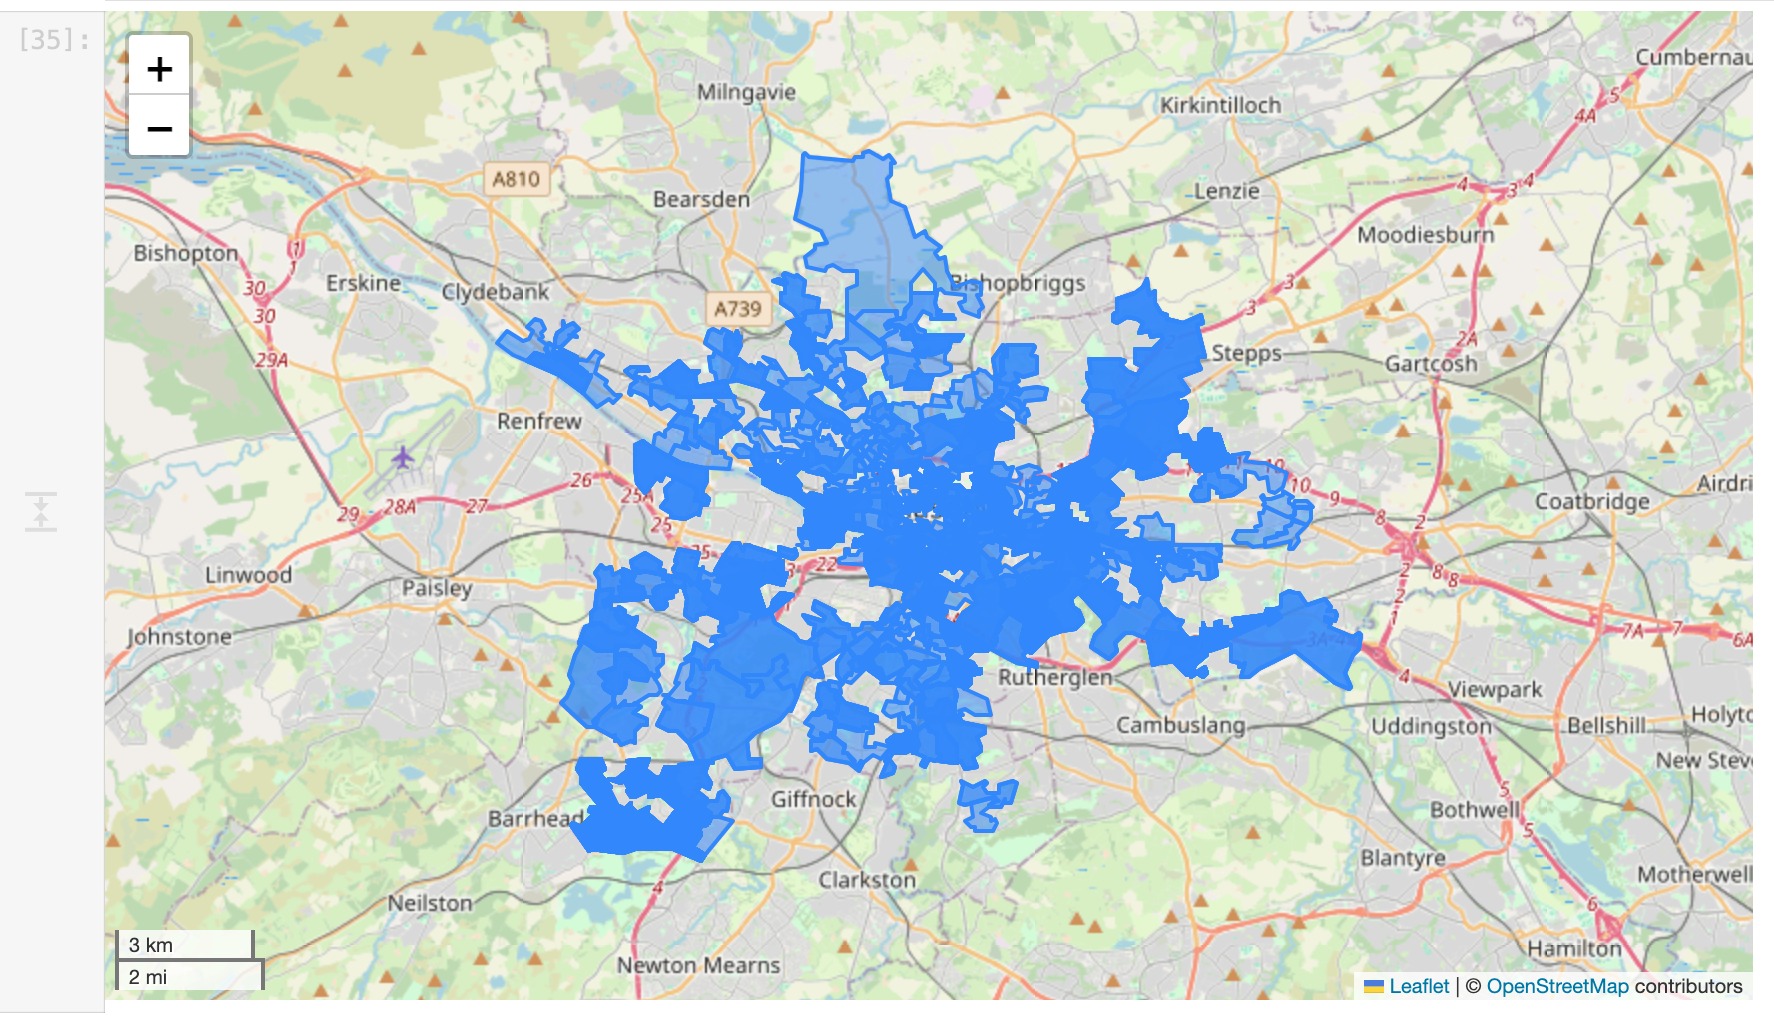

# References

- GeoPandas (2024) *geopandas.clip*. Available at: https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html (Accessed: 21st Feb 2024)
- Pandas (2024) *pandas.DataFrame.transform*. Available at: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html. (Accessed: 21st Feb 2024).